<a href="https://colab.research.google.com/github/fbeilstein/neural_networks/blob/master/lecture_2_nn_architectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Visualization Helper

try:
  from torchview import draw_graph
except:
  !pip install -q torchmetrics torchinfo torchview
finally:
  from torchview import draw_graph

import re
def recolor_nodes(graph, layer_keyword, new_color):
  for i, node in enumerate(graph.visual_graph.body):
    if not layer_keyword in node:
      continue
    if "fillcolor=" in node:
      graph.visual_graph.body[i] = re.sub(
          r'fillcolor=[^,\]]+',
          f'fillcolor={new_color}',
          node
      )
    else:
      graph.visual_graph.body[i] = node.replace(
          "]", f", fillcolor={new_color}]"
      )

def restyle_graph(graph):
  recolor_nodes(graph, "Dropout", "gray")
  recolor_nodes(graph, "MaxPool", "red")
  recolor_nodes(graph, "Linear", "lightblue")
  recolor_nodes(graph, "ReLU", "yellow")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.2 MB/s eta 0:00:00


#LeNet

* Developed by Yann LeCun et al. in 1998.

* One of the first successful CNNs, applied to handwritten digit recognition (MNIST).

* Paved the way for modern deep learning in computer vision.

-----

* Uses tanh activation (ReLU was not yet popular).
* Uses average pooling, not max pooling (which became popular later).
* No Dropout or BatchNorm. These techniques didn't exist at the time. LeNet-5 is much shallower and simpler.

-----

* CNN structure idea: alternating convolution + pooling.

* Weight sharing: dramatically reduces number of parameters vs fully connected layers.

* Local receptive fields: how neurons look only at parts of the image.

* Low parameter count: around 60k parameters—tiny by modern standards!

* Bias-variance balance: good example of a simple model that avoids overfitting by design.

In [ ]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/lenet_architecture.png" width='550'>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. LeNet-5 architecture
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5)   # 28x28 -> 24x24
    self.pool1 = nn.AvgPool2d(kernel_size=2)      # 24x24 -> 12x12
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # 12x12 -> 8x8
    self.pool2 = nn.AvgPool2d(kernel_size=2)      # 8x8 -> 4x4
    self.conv3 = nn.Conv2d(16, 120, kernel_size=4)  # 4x4 -> 1x1

    self.fc1 = nn.Linear(120, 84)
    self.fc2 = nn.Linear(84, 10)

  def forward(self, x):
    x = torch.tanh(self.conv1(x))
    x = self.pool1(x)
    x = torch.tanh(self.conv2(x))
    x = self.pool2(x)
    x = torch.tanh(self.conv3(x))
    x = x.view(-1, 120)
    x = torch.tanh(self.fc1(x))
    x = self.fc2(x)
    return x


In [ ]:
# 2. Prepare data
transform = transforms.Compose([
  transforms.Resize((28, 28)),  # Just to be sure
  transforms.ToTensor()
])

train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
test_data  = datasets.MNIST(root='data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=1000, shuffle=False)

# 3. Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training loop
for epoch in range(5):
  model.train()
  total_loss = 0
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 55.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.72MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.08MB/s]


Epoch 1, Loss: 294.13
Epoch 2, Loss: 96.04
Epoch 3, Loss: 66.10
Epoch 4, Loss: 50.09
Epoch 5, Loss: 40.33


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 98.45%


#AlexNet

* Breakthrough: AlexNet won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2012 by a huge margin.

* Popularized CNNs: It showed that convolutional neural networks trained on GPUs could achieve state-of-the-art results on real-world large-scale datasets.

* Catalyst for Deep Learning: It essentially started the current deep learning boom in computer vision.

--------

**New Features/Ideas**

* Deep Architecture
* ReLU Activation	instead of tanh/sigmoid for faster convergence
* Introduced dropout to prevent overfitting in fully connected layers
* Used overlapping $3\times 3$ pooling (stride 2) instead of $2 \times 2$ non-overlapping
* Used data augmentation techniques like image translation and reflection to expand dataset
* Trained on 2 GPUs, splitting the model across them (early model parallelism)
* Used Local Response Normalization (LRN) to encourage lateral inhibition (now less common)

In [ ]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/alexnet_architecture.png" width='550'>

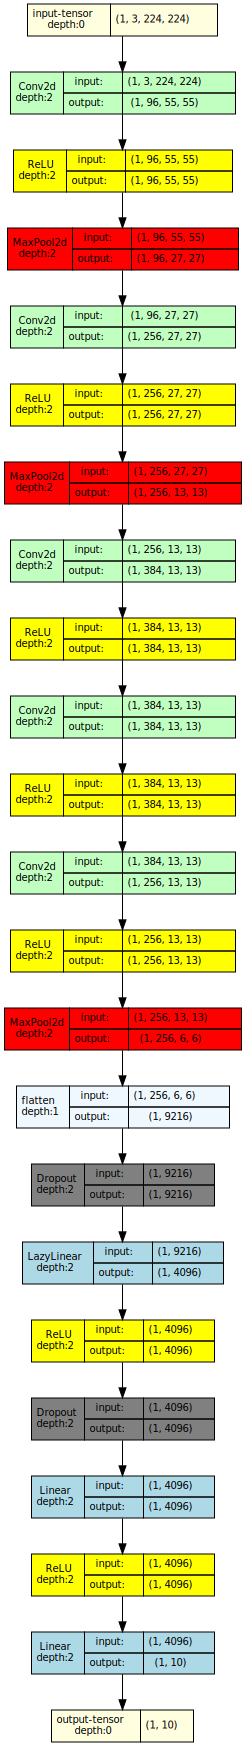

In [ ]:
#@title AlexNet architecture

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim

# Define AlexNet for CIFAR-10 (input 3x32x32 instead of 224x224)
class AlexNet(nn.Module):
  def __init__(self, num_classes=10):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  # CIFAR-10: input 32x32, here causes strong shrink
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
      nn.Conv2d(96, 256, kernel_size=5, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
      nn.Conv2d(256, 384, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(384, 384, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(384, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.classifier = nn.Sequential(
      nn.Dropout(),
      nn.LazyLinear(4096),
      nn.ReLU(inplace=True),
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.ReLU(inplace=True),
      nn.Linear(4096, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(num_classes=10).to(device)


model_graph = draw_graph(model, input_size=[1,3,224,224], expand_nested=False, graph_dir='UD',)
model_graph.resize_graph(scale=5.0)
restyle_graph(model_graph)
model_graph.visual_graph

#VGG16 (Visual Geometry Group Network)

In [ ]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/vgg16_architecture.png" width=550>


**VGG16 (Visual Geometry Group Network, 2014)**

Deep convolutional neural network for image classification.
Key idea: Use many small (3x3) convolutions stacked deeply instead of fewer large filters.

**Architecture**

* Convolutions: Stacks of 3x3 conv layers (stride 1, padding 1) → captures fine details with fewer parameters.
* After every few convs → MaxPool (2x2, stride 2) halves spatial resolution.
* Depth: 13 conv layers + 3 fully connected layers → 16 weight layers (hence VGG16).
* Classifier: Flatten → 2xFC (4096 units each) → FC output for 1000 ImageNet classes.

**Why VGG16 Works**

* Small filters give deeper, more expressive networks with manageable parameter count.
* Uniform architecture (only 3x3 conv + 2x2 pooling) → simple, elegant design.
* Strong baseline model for feature extraction & transfer learning.

**Applications**

* Image classification (ImageNet benchmark, 2014).
* Widely used backbone in vision tasks before ResNet.
* Still popular as a feature extractor in transfer learning.

#FCN32 (Fully Convolutional Network for Segmentation)

In [ ]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/fcn32_architecture.png" width=550>


**FCN32 (Fully Convolutional Network for Segmentation, 2015)**

First major CNN adapted for semantic segmentation.

**Key idea:** Replace fully connected layers with convolutions → allows per-pixel classification.

**Architecture**

* Backbone: Often uses pretrained classification nets (e.g. VGG16) as encoder.
* Fully connected layers are replaced by 1x1 convolutions.
* Upsampling (deconvolution / transpose conv): Feature maps are upsampled by a factor of 32 → original image resolution.
* Produces coarse segmentation masks.

**Variants:**

FCN16, FCN8 improve localization by fusing encoder features from shallower layers (skip connections).

**Why FCN32 Works**

* Converts classification networks into segmentation networks.
* End-to-end trainable: input image → output segmentation map.
* First step toward modern encoder-decoder designs (like U-Net).
* Limitation: coarse output (32x downsampled, blurry borders).

**Applications**

* General semantic segmentation.
* Proof-of-concept that CNNs can do dense prediction, not just classification.
* Foundation for more refined models (U-Net, DeepLab, etc.).

#ResNet

In [ ]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/Resnet18_architecture.svg" width=750>


**ResNet (Residual Network)**

* Deep neural network designed to ease training of very deep architectures.
* Key idea: Residual connections (skip connections) allow layers to learn only the difference (residual) from identity mapping.

**Architecture**

* Building block: Residual block
* Input → Convolution(s) → Output
* Plus a shortcut connection that adds the original input back to the output.

**Types of residual blocks:**

* Basic block (used in ResNet-18, ResNet-34): two $3\times 3$ convolutions + skip connection.
* Bottleneck block (used in deeper ResNets): $1\times 1$ conv (reduce dims) → $3\times 3$ conv → $1\times 1$ conv (restore dims) + skip.
* If input/output dimensions differ, shortcut uses $1\times 1$ conv to match shapes.
* Network is a stack of residual blocks with pooling at start and global average pooling at end → classifier.

------

**Why Residual Connections Help**

* Deep plain networks suffer from vanishing gradients and degradation problem (accuracy worsens as depth increases).
* Skip connections let gradients flow directly through identity paths.
* Model can easily learn identity mapping if deeper layers are unnecessary → prevents performance drop.

-------

**Applications**

* Image classification (ImageNet benchmark winner, 2015).
* Backbone for many CV architectures: object detection (Faster R-CNN), segmentation (Mask R-CNN, U-Net variants).
* Adapted to NLP, speech, and other domains where deep models are useful.

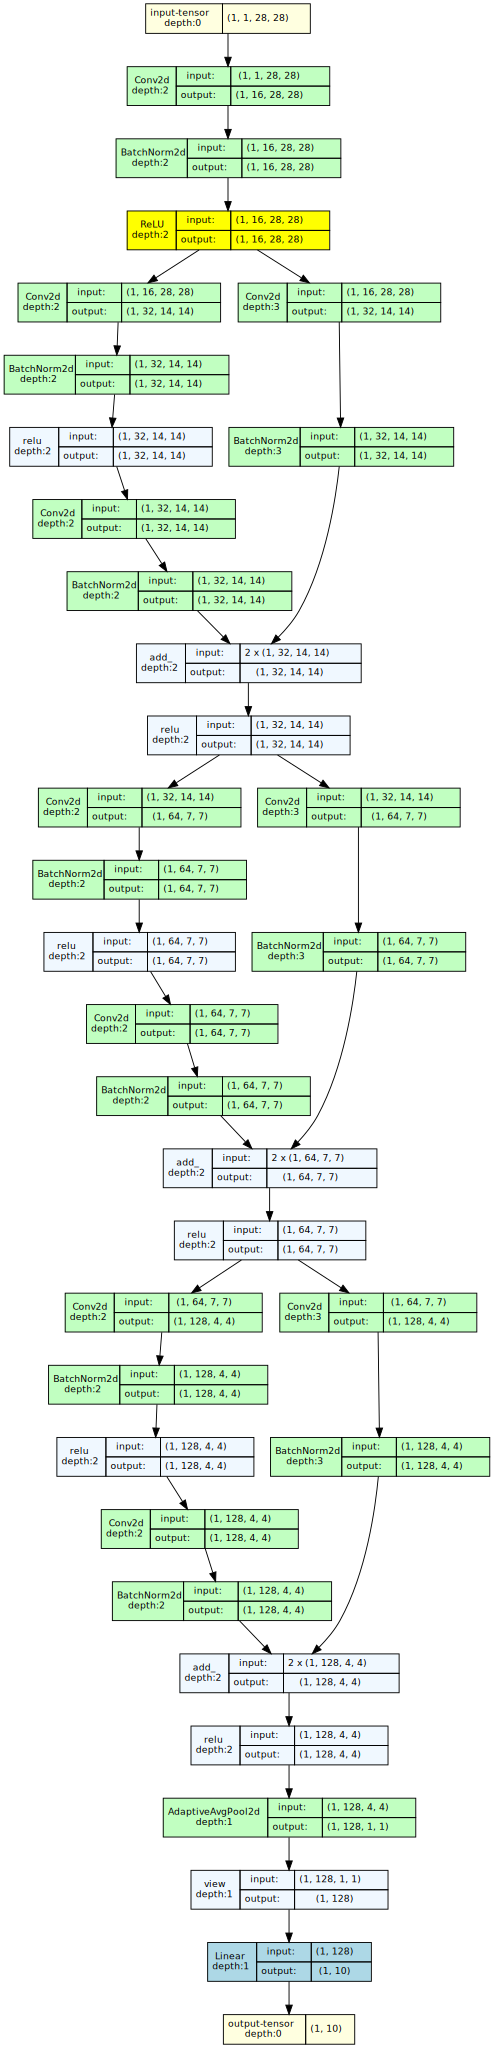

In [ ]:
# ResNet (ResNet18-like) for MNIST classification

import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                            stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                            stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1,
                  stride=stride, bias=False),
        nn.BatchNorm2d(out_channels))

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    return F.relu(out)

class ResNetSmall(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.init_conv = nn.Sequential(
      nn.Conv2d(1, 16, 3, 1, 1),
      nn.BatchNorm2d(16),
      nn.ReLU())

    self.layer1 = BasicBlock(16, 32, stride=2)
    self.layer2 = BasicBlock(32, 64, stride=2)
    self.layer3 = BasicBlock(64, 128, stride=2)

    self.pool = nn.AdaptiveAvgPool2d(1)
    self.fc = nn.Linear(128, num_classes)

  def forward(self, x):
    x = self.init_conv(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.pool(x)
    x = x.view(x.size(0), -1)
    return self.fc(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetSmall().to(device)

model_graph = draw_graph(model, input_size=[1,1,28,28], expand_nested=False, graph_dir='UD',)
model_graph.resize_graph(scale=5.0)
restyle_graph(model_graph)
model_graph.visual_graph

In [ ]:
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=1000, shuffle=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(5):  # Keep it short for demo
  model.train()
  running_loss = 0.0
  for inputs, labels in trainloader:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 347kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.73MB/s]


Epoch 1, Loss: 0.1276
Epoch 2, Loss: 0.0361
Epoch 3, Loss: 0.0262
Epoch 4, Loss: 0.0190
Epoch 5, Loss: 0.0183
Accuracy on test set: 99.16%


#Autoencoder

In [ ]:
#@title Manual PCA
%%html
<iframe title="Demo"
        src="https://fbeilstein.github.io/machine_learning/lecture_12_principal_component_analysis/demo_pca.html"
        width="800" height="450"
        marginwidth="0" marginheight="0" frameborder="0"
        scrolling="no">
Your browser does not support IFrames.
</iframe>


In [ ]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/autoencoder_architecture.webp" height=400>


**Autoencoder**

* Neural network trained to reconstruct input from a compressed internal representation.
* Consists of:
  - Encoder: Maps input → latent space.
  - Decoder: Reconstructs input from latent code.
* Unsupervised learning: No labels needed during training.

--------

**Architecture**
* Symmetric structure: Encoder and decoder mirror each other.
* Common layers: Fully connected (dense), Convolutional (for images)
* Bottleneck layer: Represents compressed features.

-------

**Applications**
* Dimensionality reduction (alternative to PCA)
* Denoising: Removes noise from corrupted input
* Anomaly detection: Poor reconstruction signals anomaly
* Image compression and synthesis

**Denoising Autoencoders**
* Trained with noisy input but clean target.
* Learns to map noisy → clean data.
* Helps the model extract robust features.

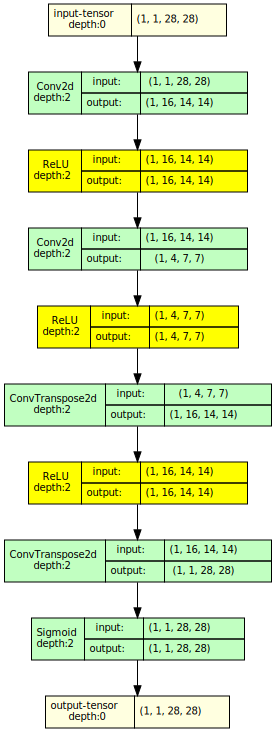

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np


class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 16, 3, stride=2, padding=1),  # 16x14x14
      nn.ReLU(),
      nn.Conv2d(16, 4, 3, stride=2, padding=1),  # 4x7x7
      nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(4, 16, 3, stride=2, output_padding=1, padding=1),  # 16x14x14
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1, padding=1),  # 1x28x28
        nn.Sigmoid()
      )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)

model_graph = draw_graph(model, input_size=[1,1,28,28], expand_nested=False, graph_dir='UD',)
model_graph.resize_graph(scale=5.0)
restyle_graph(model_graph)
model_graph.visual_graph

In [ ]:
class NoisyMNIST(Dataset):
  def __init__(self, train=True):
    self.data = datasets.MNIST(root='./data', train=train, download=True,
                                transform=transforms.ToTensor())

  def __getitem__(self, index):
    img, label = self.data[index]
    noisy_img = img + 0.5 * torch.randn_like(img)  # add Gaussian noise
    noisy_img = torch.clip(noisy_img, 0., 1.)
    return noisy_img, img

  def __len__(self):
    return len(self.data)


train_loader = DataLoader(NoisyMNIST(train=True), batch_size=128, shuffle=True)
test_loader = DataLoader(NoisyMNIST(train=False), batch_size=10, shuffle=False)


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.30MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.24MB/s]


In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):
  model.train()
  loss_sum = 0
  for noisy, clean in train_loader:
    noisy, clean = noisy.to(device), clean.to(device)
    output = model(noisy)
    loss = criterion(output, clean)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_sum += loss.item()
  print(f"Epoch {epoch+1}, Loss: {loss_sum / len(train_loader):.4f}")


Epoch 1, Loss: 0.0595
Epoch 2, Loss: 0.0190
Epoch 3, Loss: 0.0177
Epoch 4, Loss: 0.0171
Epoch 5, Loss: 0.0164


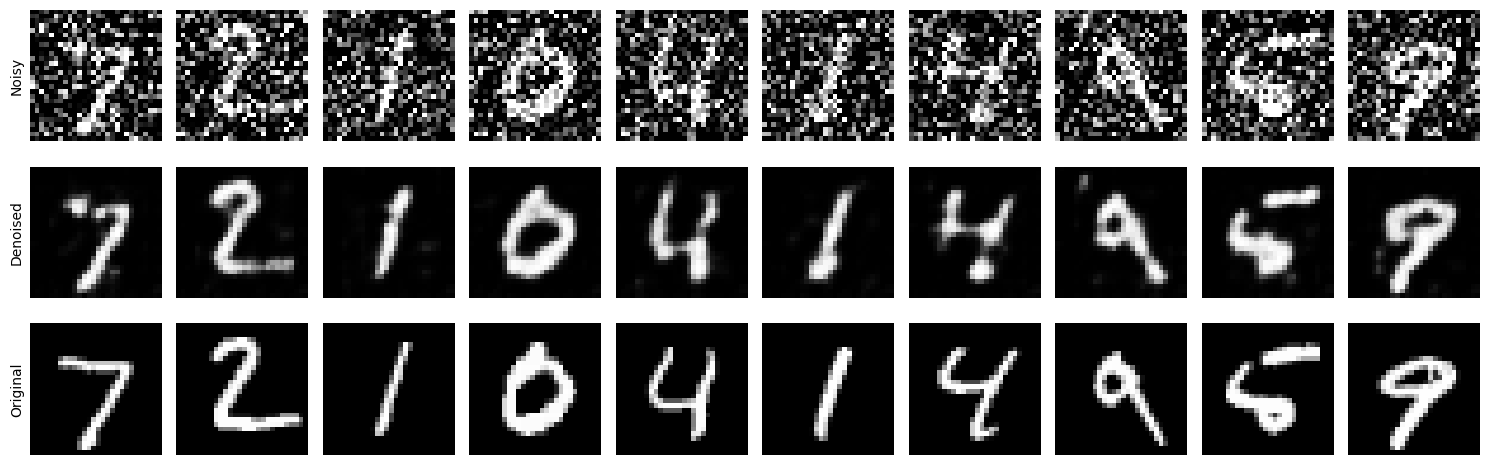

In [ ]:
model.eval()
noisy_imgs, clean_imgs = next(iter(test_loader))
with torch.no_grad():
  noisy_imgs = noisy_imgs.to(device)
  reconstructed = model(noisy_imgs).cpu()

# Plotting
def show_images(noisy, reconstructed, original):
  fig, axs = plt.subplots(3, 10, figsize=(15, 5))
  for i in range(10):
    axs[0, i].imshow(noisy[i][0], cmap='gray')
    axs[1, i].imshow(reconstructed[i][0], cmap='gray')
    axs[2, i].imshow(original[i][0], cmap='gray')
    for ax in axs[:, i]:
      #ax.axis('off')
      ax.spines[:].set_visible(False)
      ax.set_xticks([])
      ax.set_yticks([])
  axs[0, 0].set_ylabel("Noisy")
  axs[1, 0].set_ylabel("Denoised")
  axs[2, 0].set_ylabel("Original")
  plt.tight_layout()
  plt.show()

show_images(noisy_imgs.cpu(), reconstructed, clean_imgs)


#Variational Autoencoder (VAE)

In [ ]:
#@title #General Idea
%%html
<link rel="stylesheet" href="https://fbeilstein.github.io/machine_learning/js_common/styles.css"/>
<script src="https://fbeilstein.github.io/machine_learning/js_common/script.js"></script>
<script>
load_slides_from(
[`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/VAE1.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/VAE2.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/VAE3.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/VAE4.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/VAE5.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/VAE6.webp" width=750>
`])

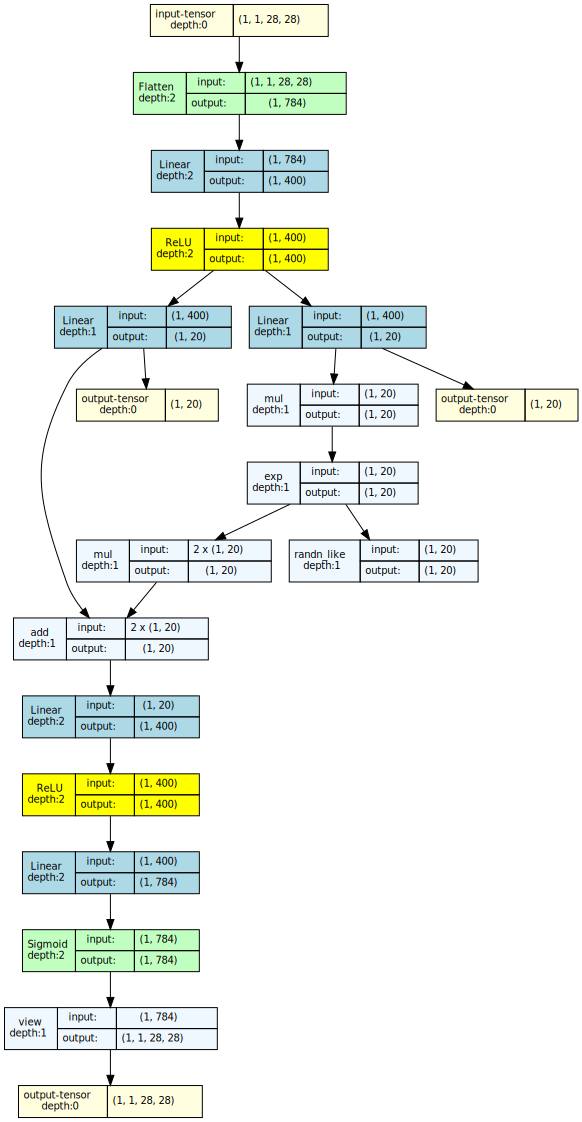

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


class VAE(nn.Module):
  def __init__(self, latent_dim=20):
    super(VAE, self).__init__()
    self.encoder = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 400),
      nn.ReLU(),
    )
    self.fc_mu = nn.Linear(400, latent_dim)
    self.fc_logvar = nn.Linear(400, latent_dim)

    self.decoder = nn.Sequential(
      nn.Linear(latent_dim, 400),
      nn.ReLU(),
      nn.Linear(400, 28*28),
      nn.Sigmoid()  # output in [0,1]
    )

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std  # reparameterization trick

  def forward(self, x):
    x = self.encoder(x)
    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    z = self.reparameterize(mu, logvar)
    recon = self.decoder(z)
    return recon.view(-1, 1, 28, 28), mu, logvar


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(latent_dim=20).to(device)

model_graph = draw_graph(model, input_size=[1,1,28,28], expand_nested=False, graph_dir='UD',)
model_graph.resize_graph(scale=5.0)
restyle_graph(model_graph)
model_graph.visual_graph

In [ ]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root="data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
  recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
  kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
  return recon_loss + kl_div

for epoch in range(1, 11):
  model.train()
  total_loss = 0
  for x, _ in train_loader:
    x = x.to(device)
    recon_x, mu, logvar = model(x)
    loss = loss_function(recon_x, x, mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader.dataset):.2f}")

Epoch 1, Loss: 164.21
Epoch 2, Loss: 121.29
Epoch 3, Loss: 114.59
Epoch 4, Loss: 111.66
Epoch 5, Loss: 109.97
Epoch 6, Loss: 108.72
Epoch 7, Loss: 107.86
Epoch 8, Loss: 107.24
Epoch 9, Loss: 106.67
Epoch 10, Loss: 106.27


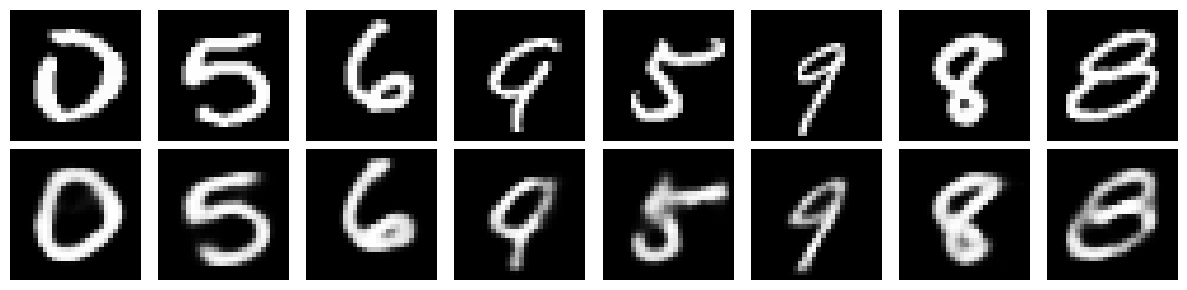

In [ ]:
model.eval()
with torch.no_grad():
  x, _ = next(iter(train_loader))
  x = x.to(device)
  recon_x, m, v = model(x)

  fig, axs = plt.subplots(2, 8, figsize=(12, 3))
  for i in range(8):
    axs[0, i].imshow(x[i].cpu().squeeze(), cmap="gray")
    axs[1, i].imshow(recon_x[i].cpu().squeeze(), cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].axis("off")
  axs[0, 0].set_ylabel("Input")
  axs[1, 0].set_ylabel("Recon")
  plt.tight_layout()
  plt.show()

#U-Net

In [ ]:
#@title architecture
%%html
<img src="https://raw.githubusercontent.com/fbeilstein/presentations/master/images/nn_architectures/unet_architecture.png" width=550>


Neural network architecture designed for **image segmentation**, especially in biomedical imaging.

**Key idea:** Encoder-decoder structure with skip connections → combines global context (from encoder) with fine localization (from decoder).


---


**Architecture**

* Encoder (contracting path)
  - Each step halves spatial resolution, doubles feature channels
  - Captures context (what is in the image).
* Decoder (expanding path)
  - Up-convolutions (transpose conv / bilinear upsampling + conv)
  - Each step doubles resolution, halves feature channels
  - Restores spatial detail (where objects are).
* Skip connections
  - Feature maps from encoder are concatenated with corresponding decoder layers.
  - Preserves fine-grained spatial information lost during pooling.
* Final layer
  - maps decoder features to segmentation mask (per-pixel class probabilities).

**Why U-Net Works**

* Encoders extract hierarchical features (shapes, textures, semantics).
* Decoders alone would be blurry → skip connections inject high-resolution details.
* Allows precise pixel-level predictions with relatively few training images.


**Applications**

* Biomedical imaging (cell/nucleus segmentation, tumor detection).
* Satellite / aerial imagery (roads, buildings, land cover).
* General semantic segmentation (objects, backgrounds).
* Variants adapted for 3D volumes (medical CT/MRI), attention mechanisms, and multi-task learning.

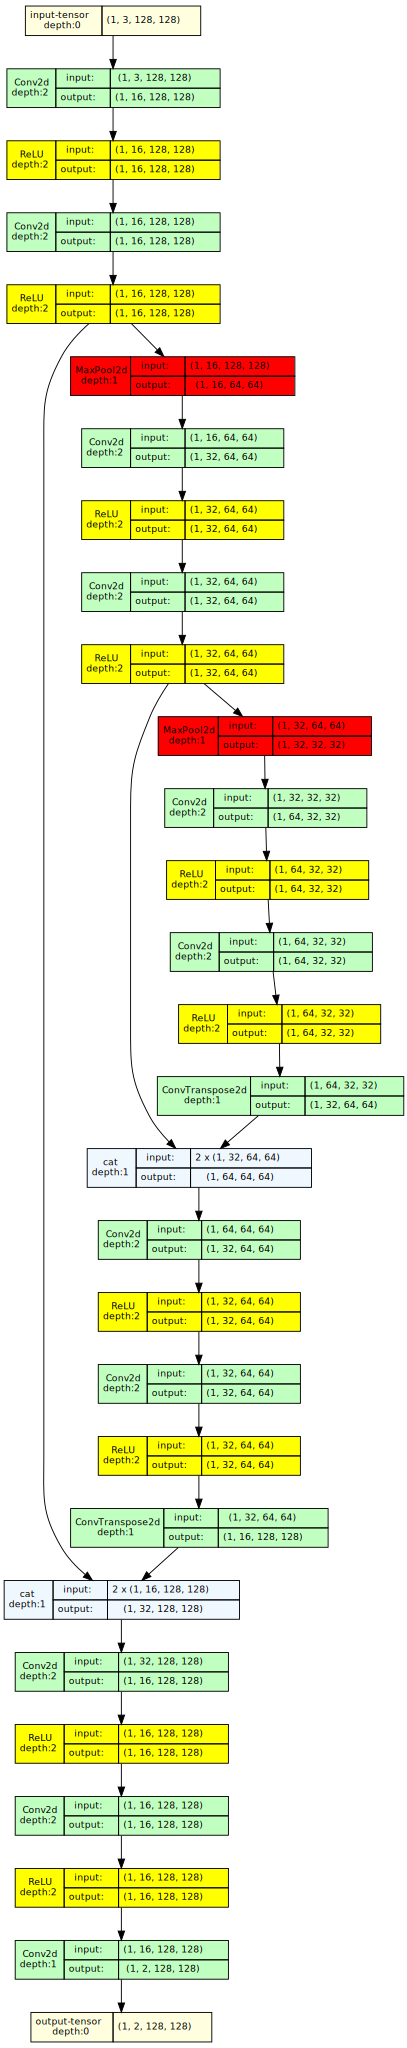

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class UNet(nn.Module):
  def __init__(self):
    super().__init__()
    def C(in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1), nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.ReLU()
        )
    self.enc1 = C(3, 16)
    self.enc2 = C(16, 32)
    self.enc3 = C(32, 64)
    self.pool = nn.MaxPool2d(2)
    self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
    self.dec2 = C(64, 32)
    self.up1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
    self.dec1 = C(32, 16)
    self.outc = nn.Conv2d(16, 2, 1)

  def forward(self, x):
    e1 = self.enc1(x)
    e2 = self.enc2(self.pool(e1))
    e3 = self.enc3(self.pool(e2))
    d2 = self.up2(e3)
    d2 = self.dec2(torch.cat([d2, e2], dim=1))
    d1 = self.up1(d2)
    d1 = self.dec1(torch.cat([d1, e1], dim=1))
    return self.outc(d1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

model_graph = draw_graph(model, input_size=[1,3,128,128], expand_nested=False, graph_dir='UD',)
model_graph.resize_graph(scale=5.0)
restyle_graph(model_graph)
model_graph.visual_graph

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os

# Download Oxford-IIIT Pet dataset
dataset = torchvision.datasets.OxfordIIITPet(
  root=".",
  split="trainval",
  target_types="segmentation",
  download=True,
)

# Filter cats only
cat_classes = ["Abyssinian", "Bengal", "Birman", "Bombay", "British_Shorthair",
               "Egyptian_Mau", "Maine_Coon", "Persian", "Ragdoll",
               "Russian_Blue", "Siamese", "Sphynx"]

cat_indices = [i for i, c in enumerate(dataset._labels) if dataset.classes[c] in cat_classes]

class CatSegmentation(Dataset):
  def __init__(self, dataset, indices, size=128):
    self.dataset = dataset
    self.indices = indices
    self.t_img = T.Compose([
      T.Resize((size,size)),
      T.ToTensor()
    ])
    self.t_mask = T.Compose([
      T.Resize((size,size), interpolation=T.InterpolationMode.NEAREST),
      T.PILToTensor()
    ])

  def preprocess_mask(self, mask_old):
      mask = mask_old.clone().float()
      mask[mask_old == 1] = 1.0   # background
      mask[mask_old == 2] = 0.0   # border
      mask[mask_old == 3] = 0.5   # cat
      return mask

  def __len__(self):
    return len(self.indices)

  def __getitem__(self, idx):
    img, mask = self.dataset[self.indices[idx]]

    return self.t_img(img), self.preprocess_mask(self.t_mask(mask)[0])

cats = CatSegmentation(dataset, cat_indices, size=64)
train_loader = DataLoader(cats, batch_size=16, shuffle=True)


100%|██████████| 792M/792M [00:34<00:00, 23.2MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 11.2MB/s]


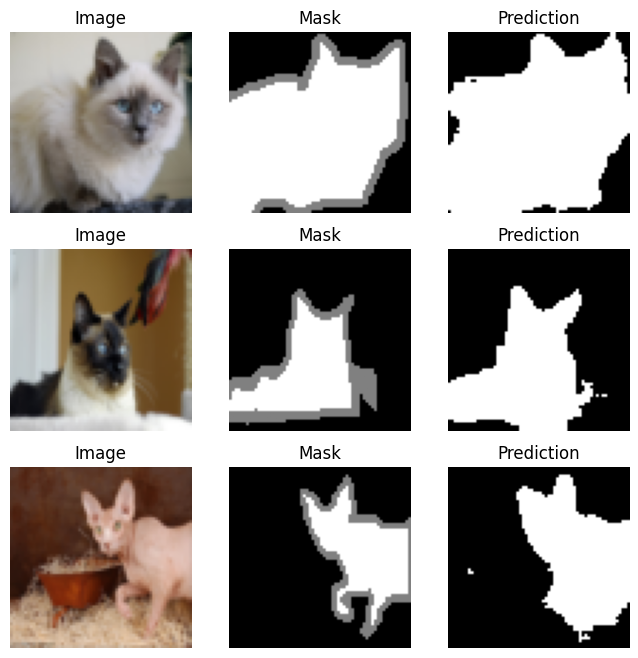

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(100):
  for imgs, masks in train_loader:
    imgs, masks = imgs.to(device), masks.to(device)
    logits = model(imgs)
    loss = criterion(logits, (masks > 0.1).long())
    opt.zero_grad()
    loss.backward()
    opt.step()
  print(f"Epoch {epoch+1}, loss {loss.item():.4f}")

from google.colab import output
output.clear()

model.eval()
imgs, masks = next(iter(train_loader))
with torch.no_grad():
  preds = model(imgs.to(device)).argmax(1).cpu()

fig, axs = plt.subplots(3, 3, figsize=(8,8))
for i in range(3):
  axs[i,0].imshow(imgs[i].permute(1,2,0))
  axs[i,0].set_title("Image")
  axs[i,1].imshow(masks[i], cmap="gray")
  axs[i,1].set_title("Mask")
  axs[i,2].imshow(preds[i], cmap="gray")
  axs[i,2].set_title("Prediction")
  for j in range(3): axs[i,j].axis("off")
plt.show()

#GAN

In [2]:
#@title ##GAN style transfer
%%html


<div id="slide_6" style="display:none; max-width:750px; height:200px;">
  <img src="https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_01_introduction/Cat.jpg"
  style="position:absolute; left:0px;  top:0px;">
  <img src="https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_01_introduction/Candinsky.jpg"
  style="position:absolute; left:400px; top:0px;">
</div>

<div id="slide_7" style="display:none; max-width:750px; height:200px;">
  <img src="https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_01_introduction/Cat.jpg"
  style="position:absolute; left:0px;  top:0px;" id="cat">
  <img src="https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_01_introduction/CandinskyCat.jpg"
  style="position:absolute; left:200px; top:0px;" id="merge">
  <img src="https://raw.githubusercontent.com/fbeilstein/machine_learning/master/lecture_01_introduction/Candinsky.jpg"
  style="position:absolute; left:400px; top:0px;" id="pic">
</div>



<div style="position:absolute; top:100px; left:650px;">

<div id="arrow_left" style="border-width: 1px; border-style:solid; float:left; height:32px;">
<svg width="8.7464mm" height="8.7464mm" version="1.1" viewBox="0 0 8.7464 8.7464" xmlns="http://www.w3.org/2000/svg" xmlns:cc="http://creativecommons.org/ns#" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">
<metadata>
<rdf:RDF>
<cc:Work rdf:about="">
<dc:format>image/svg+xml</dc:format>
<dc:type rdf:resource="http://purl.org/dc/dcmitype/StillImage"/>
<dc:title/>
</cc:Work>
</rdf:RDF>
</metadata>
<g transform="translate(-38.564 -29.908)">
<rect x="38.564" y="29.908" width="8.7464" height="8.7464" fill-opacity=".16425" opacity=".97" stroke-miterlimit="10.433" stroke-width="0"/>
<path d="m45.796 34.331h-5.8931" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
<path d="m40.068 34.267 2.7141-2.4238" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
<path d="m40.069 34.396 2.7141 2.4238" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
</g>
</svg>
</div>

<div id="arrow_right" style="border-width: 1px; border-style:solid; float:right; height:32px;">
<svg width="8.7464mm" height="8.7464mm" version="1.1" viewBox="0 0 8.7464 8.7464" xmlns="http://www.w3.org/2000/svg" xmlns:cc="http://creativecommons.org/ns#" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">
<metadata>
<rdf:RDF>
<cc:Work rdf:about="">
<dc:format>image/svg+xml</dc:format>
<dc:type rdf:resource="http://purl.org/dc/dcmitype/StillImage"/>
<dc:title/>
</cc:Work>
</rdf:RDF>
</metadata>
<g transform="translate(-38.564 -29.908)">
<rect transform="scale(-1,1)" x="-47.31" y="29.908" width="8.7464" height="8.7464" fill-opacity=".16425" opacity=".97" stroke-miterlimit="10.433" stroke-width="0"/>
<path d="m40.078 34.331h5.8931" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
<path d="m45.806 34.267-2.7141-2.4238" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
<path d="m45.805 34.396-2.7141 2.4238" fill="none" stroke="#fff" stroke-opacity=".98068" stroke-width=".5"/>
</g>
</svg>
</div>

</div>

<style>
#arrow_left:hover{color:blue;}
#arrow_right:hover{color:blue;}
</style>

<script  type="text/javascript">
var slides = ["slide_6", "slide_7"];
var left_btn_id = "arrow_left";
var right_btn_id = "arrow_right";
var current_slide = 0;
var merging = false;

function slide_left()
{
  var old_slide = document.getElementById(slides[current_slide]);
  current_slide -= 1;
  if (current_slide < 0) {current_slide = 0;}
  var new_slide = document.getElementById(slides[current_slide]);
  old_slide.style.display='none';
  new_slide.style.display='block';
  if (current_slide != 5)
      merging = false;
}

function slide_right()
{
  var old_slide = document.getElementById(slides[current_slide]);
  current_slide += 1;
  if (current_slide >= slides.length) {current_slide = slides.length - 1;}
  var new_slide = document.getElementById(slides[current_slide]);
  old_slide.style.display='none';
  new_slide.style.display='block';
  if (current_slide == 1)
  {
    if (!merging)
      merge_images(200);
    merging = true;
  } else {
    merging = false;
  }
}

function image_opacity(image, opacity)
{
    var s = image.style;
    s.opacity = (opacity / 100);
    s.MozOpacity = (opacity / 100);
    s.KhtmlOpacity = (opacity / 100);
    s.filter = 'alpha(opacity=' + opacity + ')';
}

function merge_images(cycles_left)
{
  document.getElementById("cat").style.left = (200 - cycles_left) + "px";
  document.getElementById("pic").style.left = (400 - (200 - cycles_left)) + "px";
  image_opacity(document.getElementById("cat"), cycles_left / 2)
  image_opacity(document.getElementById("pic"), cycles_left / 2)
  image_opacity(document.getElementById("merge"), 100 - cycles_left / 2)
  if (cycles_left > 0)
    setTimeout(function(){merge_images(cycles_left - 1);}, 3);
}

document.getElementById(left_btn_id).addEventListener("click", slide_left);
document.getElementById(right_btn_id).addEventListener("click", slide_right);
document.getElementById(slides[current_slide]).style.display='block';
</script>

In [ ]:
#@title #General Idea
%%html
<link rel="stylesheet" href="https://fbeilstein.github.io/machine_learning/js_common/styles.css"/>
<script src="https://fbeilstein.github.io/machine_learning/js_common/script.js"></script>
<script>
load_slides_from(
[`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/GAN1.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/GAN2.webp" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/GAN3.webp" width=750>
`])

for details see "*Generative Adversarial Nets*" by Ian J. Goodfellow et all.


**for** number of training iterations **do**

$~~~~$**for** $k$ steps **do**

$~~~~$$~~~~$• Sample minibatch of $m$ noise samples $\{z^{(1)},\dots,z^{(m)}\}$ from noise prior $p_g(z)$.

$~~~~$$~~~~$• Sample minibatch of $m$ examples $\{x^{(1)},\dots,x^{(m)}\}$ from data generating distribution $p_\text{data}(x)$.

$~~~~$$~~~~$• Update the discriminator by ascending its stochastic gradient:
$$
\nabla_{\theta_d} \frac{1}{m} \sum_{i=1}^m \left[ \ln D (x^{(i)}) + \ln \left( 1 - D(G(z^{(i)})) \right)\right]
$$
$~~~~$**end for**

$~~~~$• Sample minibatch of $m$ noise samples $\{z^{(1)},\dots,z^{(m)}\}$ from noise prior $p_g(z)$.

$~~~~$• Update the generator by descending its stochastic gradient:
$$
\nabla_{\theta_g} \frac{1}{m} \sum_{i=1}^m \ln \left( 1 - D(G(z^{(i)})) \right)
$$

**end for**

$D$ - probability that data is genuine.

For perfect discriminator $D(x) = 1$ and $D(G(z)) = 0$. In this case $\ln D + \ln(1-D(G)) = 0$ while for any other case $< 0$. **Discriminator maximizes loss**.

$G$ - would be perfect if $D(G) = 1$, thus loss would be $-\infty$. **Generator minimizes loss**

$$
\min_G \max_D \frac{1}{m} \sum_{i=1}^m \left[ \ln D (x^{(i)}) + \ln \left( 1 - D(G(z^{(i)})) \right)\right]
$$

![img](https://upload.wikimedia.org/wikipedia/commons/thumb/1/17/Inter-house_sports-_tug_of_war.jpg/640px-Inter-house_sports-_tug_of_war.jpg)

It can be proven that balance is acieved when $D(x) = D(G(z)) = 1/2$, that basically means genuine and generated data are indistinguishable.

#RNN

**Core Ideas**

* **Purpose:** Handle sequential data (text, speech, time series, etc.) by preserving context across time steps.

* **Key principle:** Output at time $t$ depends on current input and previous hidden state
![img](https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/recurrent_neural_network_unfold.png)

* Hidden state acts as a short-term memory.

* Same weights are reused at every time step → temporal parameter sharing.

* Can learn dependencies across time (e.g., next word prediction, pattern recognition).

* Limitation: Gradients vanish/explode for long sequences → memory fades quickly.

* Today mostly replaced by Transformers, but still excellent for illustrating temporal recurrence and state propagation.

* **Applications:**
  - Text generation
  - Speech recognition
  - Signal/time-series forecasting
  - Music or handwriting generation


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# --- Data: simple repeating pattern ---
text = "ABCABCABCABCABC"
chars = sorted(list(set(text)))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}

# Encode
input_seq = [char_to_idx[ch] for ch in text[:-1]]
target_seq = [char_to_idx[ch] for ch in text[1:]]

x = torch.eye(len(chars))[input_seq].unsqueeze(0)  # one-hot encode, shape (1, seq, vocab)
y = torch.tensor(target_seq).unsqueeze(0)

# --- Model ---
class SimpleRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
      super().__init__()
      self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
      self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, hidden=None):
    out, hidden = self.rnn(x, hidden)
    out = self.fc(out)
    return out, hidden

model = SimpleRNN(len(chars), 8, len(chars))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

# --- Training ---
for epoch in range(300):
  optimizer.zero_grad()
  out, _ = model(x)
  loss = criterion(out.squeeze(0), y.squeeze(0))
  loss.backward()
  optimizer.step()
  if epoch % 50 == 0:
    print(f"Epoch {epoch}, loss={loss.item():.4f}")

# --- Test prediction ---
hidden = None
input_char = 'A'
print("Generated sequence:")
for _ in range(10):
  inp = torch.eye(len(chars))[char_to_idx[input_char]].unsqueeze(0).unsqueeze(0)
  out, hidden = model(inp, hidden)
  pred_idx = out.argmax(dim=2).item()
  pred_char = idx_to_char[pred_idx]
  print(pred_char, end='')
  input_char = pred_char


Epoch 0, loss=1.1411
Epoch 50, loss=0.0009
Epoch 100, loss=0.0006
Epoch 150, loss=0.0004
Epoch 200, loss=0.0003
Epoch 250, loss=0.0003
Generated sequence:
BCABCABCAB

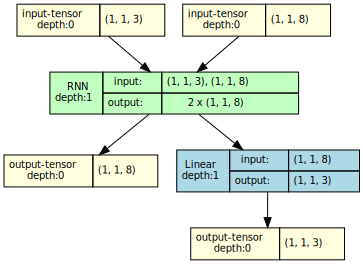

In [ ]:
model_graph = draw_graph(model, input_data=(inp, hidden), expand_nested=False, graph_dir='UD',)
model_graph.resize_graph(scale=5.0)
restyle_graph(model_graph)
model_graph.visual_graph

#LSTM

* **Purpose:** Overcome the vanishing gradient problem of standard RNNs by introducing memory control.

* **Key idea:** Add a cell state that carries long-term information, controlled by gates.

* Each LSTM unit decides:
  - what to remember (input gate)
  - what to forget (forget gate)
  - what to output (output gate)

![img](https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/LSTM.png)

Upper line: $C_t$-s. This is internal memory of the cell. Update is performed as
$$
C_t = f_t C_{t-1} + i_t C_t'.
$$
Here $f_t$ is forget gate $f_t = σ(W_f[h_t−1​,x_t​]+b_f)$, $i_t = σ(W_i[h_t−1​,x_t​]+b_i)$ - input gate, and $C'_t = \tanh(W_C[h_t−1​,x_t​]+b_C)$ - candidate state.

Lower line: outputs $h_t$. Update is performed as
$$
h_t = σ(W_o[h_t−1​,x_t​]+b_o) \tanh(C_t)
$$

#Transformer

![img](https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/transformer.png)

1. **Core Idea**
* Introduced in Vaswani et al., 2017: “Attention Is All You Need”
* Replaces recurrent and convolutional layers with self-attention mechanisms.
* Processes sequences in parallel, not step-by-step — enabling efficient training and long-range dependency modeling.

2. **Overall Structure**
* Consists of an Encoder and a Decoder, each built from stacked layers (typically 6-12).
* Both use multi-head self-attention and feed-forward sublayers, with residual connections and layer normalization.

3. **Encoder**
* Input tokens → embedded into vectors + positional encoding added.
* Each encoder layer:
  - Multi-head self-attention: each token attends to all others in the sequence.
  - Feed-forward network (FFN): applied independently to each position.
  - Outputs contextualized representations for every token.

4. **Decoder**
* Similar layered structure, but includes an additional encoder–decoder attention block.
* Each layer:
  - Masked self-attention: prevents attending to future tokens (for autoregressive generation).
  - Encoder-decoder attention: allows decoder tokens to attend to encoder outputs.
  - Feed-forward network for further transformation.

5. **Attention Mechanism**
* Based on queries (Q), keys (K), and values (V).
* Computes attention weights via scaled dot-product:
$$
\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$
* Multi-head attention: runs several attention operations in parallel to capture different relationships.

6. **Positional Encoding**
* Since Transformers lack recurrence, positions are encoded using sinusoidal or learned embeddings.
* Allows the model to distinguish token order.

7. **Advantages**
* Highly parallelizable → faster training.
* Captures long-distance dependencies effectively.
* Scales well → foundation for BERT, GPT, T5, and other large language models.

#Stable Diffusion

Stable Diffusion is not one, but few models trained jointly (at the end):

- **ClipText** for text encoding.
**Input:** text.
**Output:** 77 token embeddings vectors, each in 768 dimensions.

- **UNet** + Scheduler to gradually process/diffuse information in the information (latent) space.
**Input:** text embeddings and a starting multi-dimensional array made up of noise.
**Output:** A processed information array

- **Autoencoder Decoder** that paints the final image using the processed information array.
**Input:** The processed information array (dimensions: (4,64,64))
**Output:** The resulting image (dimensions: (3, 512, 512) which are (red/green/blue, width, height))

**Diffusion NN training**

* Dataset are images and samples of noise (can be generated on-the-fly).
* Image + noise is given to NN, expected result - predict correct noise, so that Image + noise - predicted noise = Image
* On inference random noise is sent into NN, result of inference is subtracted from the initial random noise giving a new image. Process is performed certain number of steps (remember + scheduler!).
* External information (like text embedding) is injected via cross-attention layers.

[Nice article I used](https://codoraven.com/blog/ai/stable-diffusion-clearly-explained/#codobs-toc-h-2)

In [ ]:
#@title #General Idea
%%html
<link rel="stylesheet" href="https://fbeilstein.github.io/machine_learning/js_common/styles.css"/>
<script src="https://fbeilstein.github.io/machine_learning/js_common/script.js"></script>
<script>
load_slides_from(
[`
The training of the Diffusion Model can be divided into two parts:
<ul>
<li>Forward Diffusion Process → add noise to the image.</li>
<li>Reverse Diffusion Process → remove noise from the image.</li>
</ul>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/stable_diffusion/01_diffusion_model_overview.jpg" width=750>
`,`
<h1>Training</h1>
In each epoch:

<ul>
<li>A random time step t will be selected for each training sample (image).</li>
<li>Apply the Gaussian noise (corresponding to t) to each image.</li>
<li>Convert the time steps to embeddings (vectors).</li>
</ul>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/stable_diffusion/02_create_dataset.jpg" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/stable_diffusion/03_training.jpg" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/stable_diffusion/09_sampling.jpg" width=750>
`,`
<ul>
<li>The diffusing (sampling) process iteratively feeds a full-sized image to the U-Net to get the final result.
This makes the pure Diffusion model extremely slow when the number of total diffusing steps T and the image size are large.</li>
<li>The original name of Stable Diffusion is “Latent Diffusion Model” (LDM). As its name points out, the Diffusion process happens in the latent space.
This is what makes it faster than a pure Diffusion model.</li>
<li>After encoding the images into latent data, the forward and reverse diffusion processes will be done in the latent space.
<ul>
<li>Forward Diffusion Process → add noise to the latent data.</li>
<li>Reverse Diffusion Process → remove noise from the latent data.</li>
</ul>
</li>
</ul>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/stable_diffusion/05_latent_space.jpg" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/stable_diffusion/06_latent_diffusion_overview.jpg" width=750>
`,`
The true power of the Stable Diffusion model is that it can generate images from text prompts. This is done by modifying the inner diffusion model to accept conditioning inputs.
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/stable_diffusion/07_conditioning_example.jpg" width=750>
`,`
The inner diffusion model is turned into a conditional image generator by augmenting its denoising U-Net with the cross-attention mechanism.
<br><br>
The switch in the above diagram is used to control between different types of conditioning inputs:
<ul>
<li>For text inputs, they are first converted into embeddings (vectors) using a language model (e.g. BERT, CLIP),
and then they are mapped into the U-Net via the (multi-head) Attention layer.</li>
<li>For other spatially aligned inputs (e.g. semantic maps, images, inpainting), the conditioning can be done using concatenation.</li>
</ul>
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/stable_diffusion/08_conditioning_details.jpg" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/stable_diffusion/04_sampling.jpg" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/stable_diffusion/10_architecture_diffusion_model.jpg" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/stable_diffusion/11_architecture_stable_diffusion.jpg" width=750>
`])

#NERF

In [ ]:
#@title #General Idea
%%html
<link rel="stylesheet" href="https://fbeilstein.github.io/machine_learning/js_common/styles.css"/>
<script src="https://fbeilstein.github.io/machine_learning/js_common/script.js"></script>
<script>
load_slides_from(
[`
<ul>
<li>The term neural field was popularized by Xie et al. and
describes a neural network that parametrizes a signal.
This signal usually is a single 3D scene or object but that's not mandatory.
We can also use neural fields to represent any type of signals
(discrete or continuous) such as audio or images.</li>

<li>Their most popular use is in computer graphics applications such as image
synthesis and 3D reconstruction.</li>

<li>In most neural field variations, fully connected neural networks encode
objects or scenes' properties. Importantly, one network needs to be trained
to encode (capture) a single scene. Note that in contrast with standard
machine learning, the goal is to overfit the neural network to a particular
scene. In essence, neural fields embed the scene into the weights of the network.</li>
</ul>
`,`
<h1>The typical progress of computing neural fields can be formulated as follows:</h1>
<ul>
<li>Sample coordinates of a scene.</li>
<li>Feed them to a neural network to produce field quantities.</li>
<li>Sample the field quantities from the desired reconstruction domain of the problem.</li>
<li>Map the reconstruction back to the sensor domain (e.g 2D RGB images).</li>
<li>Calculate the reconstruction error and optimize the neural network.</li>
</ul>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/nerf/nerf_nn.png" width=750>
`,`
<h1>Why use Neural Fields to represent objects?</h1>
<ul>
<li>Neural fields are very efficient and compact 3D representations of objects or scenes.</li>
<li>In contrast with voxels or meshes, they are differentiable and continuous.</li>
<li>They can also have arbitrary dimensions and resolutions.</li>
<li>They are domain agnostic and do not depend on the input for each task.</li>
</ul>
`,`
<h1>Nerf example</h1>
<table>
<tr><th>Mathematical Representation</th><th>Meaning</th></tr>

<tr><td>World coordinate \\(X\\)</td><td>3D point of an object and direction of view at this point (5 real numbers)</td></tr>
<tr><td>Field quantities \\(Y\\)</td><td>RGB color and density \\(\\sigma\\) (4 real numbers)</td></tr>
<tr><td>Field \\(\\Phi : X \\to Y\\)</td><td>Neural Network, often multilayer perceptron</td></tr>
<tr><td>Sensor coordinates \\(S\\)</td><td>Camera positioning and pixel coordinates</td></tr>
<tr><td>Measurements  \\(T\\)</td><td>Pixel color, RGB</td></tr>
<tr><td>Sensor \\(\\Omega : S \\to T\\)</td><td>Taking a picture</td></tr>
<tr><td>Forward mapping \\(F : (X \\to Y) \\to (S \\to T)\\)</td><td>Volume rendering</td></tr>
</table>
`,`
<h2>Volume Rendering</h2>
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/nerf/volumetric_ray_marching.png" width=750>
`,`
<h2>Volume Rendering: Physical Model</h2>

A light ray travels through a volume that both <b>emits</b> and <b>absorbs</b> light.
At each point along the ray:
<ul>
  <li> it may emit light with intensity \\( c(t) \\);</li>
  <li> it may absorb or scatter light according to its density \\( \\sigma(t) \\).</li>
</ul>

The camera receives only the portion of light that is not absorbed before reaching it.

<h2>Volume Rendering Integral</h2>

\\[
C(\\mathbf{r}) =
\\int_{t_{\\text{near}}}^{t_{\\text{far}}}
T(t)\\,\\sigma(\\mathbf{r}(t))\\,c(\\mathbf{r}(t), \\mathbf{d})\\,dt
\\]

where the ray is parameterized as
\\[
\\mathbf{r}(t) = \\mathbf{o} + t\\,\\mathbf{d},
\\]
with origin \\(\\mathbf{o}\\) and direction \\(\\mathbf{d}\\).

\\[
T(t) =
\\exp\\!\\left(-\\int_{t_{\\text{near}}}^{t}
\\sigma(\\mathbf{r}(s))\\,ds\\right)
\\]

Here:
<ul>
  <li> \\( c(\\mathbf{r}(t), \\mathbf{d}) \\): emitted color (radiance) at position \\(t\\),</li>
  <li> \\( \\sigma(\\mathbf{r}(t)) \\): volume density (opacity),</li>
  <li> \\( T(t) \\): transmittance — the fraction of light that survives absorption from \\(t_{\text{near}}\\) to \\(t\\).</li>
</ul>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/nerf/nerf_training.png" width=750>
`,`
<img src="https://raw.githubusercontent.com/fbeilstein/neural_networks/master/lecture_2_nn_architectures/nerf/3d_reconstruction.png" width=750>
`])

